In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rescue-object-detection/ann.json
/kaggle/input/rescue-object-detection/DRZ_rescuedataset/DRZ_rescuedataset/08450.JPG
/kaggle/input/rescue-object-detection/DRZ_rescuedataset/DRZ_rescuedataset/19812.JPG
/kaggle/input/rescue-object-detection/DRZ_rescuedataset/DRZ_rescuedataset/22735.JPG
/kaggle/input/rescue-object-detection/DRZ_rescuedataset/DRZ_rescuedataset/16916.JPG
/kaggle/input/rescue-object-detection/DRZ_rescuedataset/DRZ_rescuedataset/05938.JPG
/kaggle/input/rescue-object-detection/DRZ_rescuedataset/DRZ_rescuedataset/06122.JPG
/kaggle/input/rescue-object-detection/DRZ_rescuedataset/DRZ_rescuedataset/08536.JPG
/kaggle/input/rescue-object-detection/DRZ_rescuedataset/DRZ_rescuedataset/22706.JPG
/kaggle/input/rescue-object-detection/DRZ_rescuedataset/DRZ_rescuedataset/18054.PNG
/kaggle/input/rescue-object-detection/DRZ_rescuedataset/DRZ_rescuedataset/20513.JPG
/kaggle/input/rescue-object-detection/DRZ_rescuedataset/DRZ_rescuedataset/12666.JPG
/kaggle/input/rescue-object-d

In [2]:
!git clone https://github.com/facebookresearch/detectron2.git
%cd detectron2
!python -m pip install -e ./

Cloning into 'detectron2'...
remote: Enumerating objects: 15837, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 15837 (delta 30), reused 12 (delta 12), pack-reused 15771 (from 2)
Receiving objects: 100% (15837/15837), 6.40 MiB | 23.25 MiB/s, done.
Resolving deltas: 100% (11532/11532), done.
/kaggle/working/detectron2
Obtaining file:///kaggle/working/detectron2
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 35.3 MB/s eta 0:00:0000:01
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61396 sha256=b881ea1dfb1c174f00a7e879df1843bdde139bb267a29a8f5efd4abd48b08db8
  

In [3]:
import json
import random
import os

# Paths
full_json_path = "/kaggle/input/rescue-object-detection/ann.json"
output_dir = "/kaggle/working/split_annotations"
os.makedirs(output_dir, exist_ok=True)

# Load full COCO annotation
with open(full_json_path, 'r') as f:
    coco = json.load(f)

# Split images
images = coco['images']
annotations = coco['annotations']
random.shuffle(images)

split_ratio = 0.8  # 80% train, 20% val
split_index = int(len(images) * split_ratio)

train_images = images[:split_index]
val_images = images[split_index:]

# Create image_id sets
train_ids = set(img['id'] for img in train_images)
val_ids = set(img['id'] for img in val_images)

# Split annotations based on image_id
train_annotations = [ann for ann in annotations if ann['image_id'] in train_ids]
val_annotations = [ann for ann in annotations if ann['image_id'] in val_ids]

# Common info/categories
info = coco.get('info', {})
licenses = coco.get('licenses', [])
categories = coco['categories']

# Save new COCO JSONs
train_dict = {
    "info": info,
    "licenses": licenses,
    "images": train_images,
    "annotations": train_annotations,
    "categories": categories
}
val_dict = {
    "info": info,
    "licenses": licenses,
    "images": val_images,
    "annotations": val_annotations,
    "categories": categories
}

with open(os.path.join(output_dir, "train.json"), 'w') as f:
    json.dump(train_dict, f)
with open(os.path.join(output_dir, "val.json"), 'w') as f:
    json.dump(val_dict, f)

print(f"Train images: {len(train_images)}, Val images: {len(val_images)}")
print("Saved split JSONs to:", output_dir)


Train images: 23805, Val images: 5952
Saved split JSONs to: /kaggle/working/split_annotations


In [5]:
# Install Detectron2 (only once per session)
!pip install -q pytorch-lightning==1.9.4


import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# Import common packages
import os
import torch
import cv2
import random
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances

# Register your dataset
register_coco_instances(
    "rescue_train", {}, 
    "/kaggle/working/split_annotations/train.json", 
    "/kaggle/input/rescue-object-detection/DRZ_rescuedataset/DRZ_rescuedataset"
)

register_coco_instances(
    "rescue_val", {}, 
    "/kaggle/working/split_annotations/val.json", 
    "/kaggle/input/rescue-object-detection/DRZ_rescuedataset/DRZ_rescuedataset"
)

# Set metadata for custom classes
MetadataCatalog.get("rescue_train").thing_classes = ["fire", "vehicle", "human"]
MetadataCatalog.get("rescue_val").thing_classes = ["fire", "vehicle", "human"]
dataset_metadata = MetadataCatalog.get("rescue_train")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 827.8/827.8 kB 13.0 MB/s eta 0:00:00a 0:00:01


In [6]:
!nvidia-smi

Fri Apr  4 07:00:10 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P0             27W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [7]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(
    "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"
))
cfg.DATASETS.TRAIN = ("rescue_train",)
cfg.DATASETS.TEST = ("rescue_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
    "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"
)
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # Learning rate
cfg.SOLVER.MAX_ITER = 3000    # Adjust based on dataset size
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # fire, vehicle, human

cfg.OUTPUT_DIR = "./output_rescue"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Start training
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()


[04/04 07:00:40 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:00, 185MB/s]                             


[04/04 07:00:45 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[04/04 07:00:55 d2.utils.events]:  eta: 0:14:16  iter: 19  total_loss: 2.299  loss_cls: 1.368  loss_box_reg: 0.5817  loss_rpn_cls: 0.1612  loss_rpn_loc: 0.05183    time: 0.3725  last_time: 0.3303  data_time: 0.1043  last_data_time: 0.0555   lr: 4.9953e-06  max_mem: 2549M
[04/04 07:01:16 d2.utils.events]:  eta: 0:14:22  iter: 39  total_loss: 2.163  loss_cls: 1.293  loss_box_reg: 0.59  loss_rpn_cls: 0.2125  loss_rpn_loc: 0.07004    time: 0.3775  last_time: 0.2926  data_time: 0.1101  last_data_time: 0.0075   lr: 9.9902e-06  max_mem: 2550M
[04/04 07:01:25 d2.utils.events]:  eta: 0:14:17  iter: 59  total_loss: 1.888  loss_cls: 1.133  loss_box_reg: 0.6362  loss_rpn_cls: 0.155  loss_rpn_loc: 0.03471    time: 0.3976  last_time: 0.2828  data_time: 0.1669  last_data_time: 0.0084   lr: 1.4985e-05  max_mem: 2550M
[04/04 07:01:31 d2.utils.events]:  eta: 0:13:54  iter: 79  total_loss: 1.917  loss_cls: 0.9797  loss_box_reg: 0.6896  loss_rpn_cls: 0.1492  loss_rpn_loc: 0.06608    time: 0.3739  last_tim

In [8]:
from detectron2.engine import DefaultPredictor

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # threshold
predictor = DefaultPredictor(cfg)

image_path = "/kaggle/input/rescue-object-detection/DRZ_rescuedataset/DRZ_rescuedataset/00000.JPG"
image = cv2.imread(image_path)
outputs = predictor(image)

v = Visualizer(image[:, :, ::-1], metadata=dataset_metadata, scale=1.0)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2.imwrite("inference_result.jpg", out.get_image()[:, :, ::-1])
print("Prediction saved!")


[04/04 07:18:27 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output_rescue/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

Prediction saved!


In [9]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("rescue_val", output_dir="./output_rescue")
val_loader = build_detection_test_loader(cfg, "rescue_val")
inference_on_dataset(trainer.model, val_loader, evaluator)


[04/04 07:18:39 d2.data.datasets.coco]: Loaded 5952 images in COCO format from /kaggle/working/split_annotations/val.json
[04/04 07:18:40 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/04 07:18:40 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[04/04 07:18:40 d2.data.common]: Serializing 5952 elements to byte tensors and concatenating them all ...
[04/04 07:18:40 d2.data.common]: Serialized dataset takes 5.04 MiB
[04/04 07:18:40 d2.evaluation.evaluator]: Start inference on 5952 batches
[04/04 07:18:41 d2.evaluation.evaluator]: Inference done 11/5952. Dataloading: 0.0491 s/iter. Inference: 0.0688 s/iter. Eval: 0.0004 s/iter. Total: 0.1183 s/iter. ETA=0:11:43
[04/04 07:18:47 d2.evaluation.evaluator]: Inference done 49/5952. Dataloading: 0.0657 s/iter. Inference: 0.0684 s/iter. Eval: 0.0004 s/iter. Total: 0.1346 s/it

OrderedDict([('bbox',
              {'AP': 44.36974494097628,
               'AP50': 74.34716107589286,
               'AP75': 47.74113186941294,
               'APs': nan,
               'APm': 0.6883128341855791,
               'APl': 50.83063339808578,
               'AP-fire': 38.18059982624689,
               'AP-vehicle': 49.7551082746847,
               'AP-human': 45.173526721997284})])

[04/04 07:53:29 d2.data.datasets.coco]: Loading /kaggle/working/split_annotations/val.json takes 1.23 seconds.
[04/04 07:53:29 d2.data.datasets.coco]: Loaded 5952 images in COCO format from /kaggle/working/split_annotations/val.json
[04/04 07:53:30 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output_rescue/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

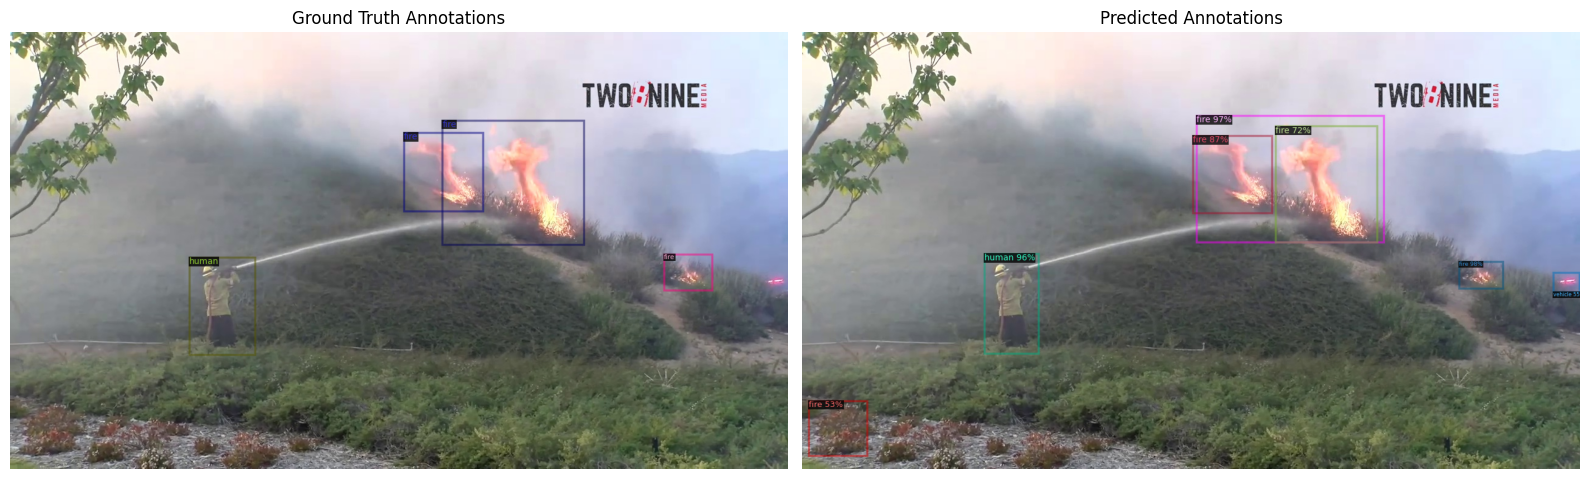

In [15]:
import cv2
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

# Load image
image_path = "/kaggle/input/rescue-object-detection/DRZ_rescuedataset/DRZ_rescuedataset/00001.JPG"
image = cv2.imread(image_path)

# Get the dataset metadata
metadata = MetadataCatalog.get("rescue_val")  # or "rescue_train" depending on which you're using

# ---- Ground Truth Visualization ----
from detectron2.data.datasets import load_coco_json

# Load annotations
dataset_dicts = load_coco_json(
    json_file="/kaggle/working/split_annotations/val.json",  # path to the annotation JSON
    image_root="/kaggle/input/rescue-object-detection/DRZ_rescuedataset/DRZ_rescuedataset",
    dataset_name="rescue_val"
)

# Find corresponding annotation for this image
image_id = image_path.split("/")[-1]
ann = next(item for item in dataset_dicts if item["file_name"].endswith(image_id))

# Visualize ground truth
v1 = Visualizer(image[:, :, ::-1], metadata=metadata, scale=1.0)
out1 = v1.draw_dataset_dict(ann)

# ---- Predicted Visualization ----
from detectron2.engine import DefaultPredictor

predictor = DefaultPredictor(cfg)
outputs = predictor(image)

# Filter out invalid predictions (in case you had extra COCO labels)
instances = outputs["instances"].to("cpu")
pred_classes = instances.pred_classes.tolist()
valid_indices = [i for i, cls in enumerate(pred_classes) if cls < len(metadata.thing_classes)]
valid_instances = instances[valid_indices]

v2 = Visualizer(image[:, :, ::-1], metadata=metadata, scale=1.0)
out2 = v2.draw_instance_predictions(valid_instances)

# ---- Plot Side by Side ----
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

axs[0].imshow(out1.get_image())
axs[0].set_title("Ground Truth Annotations")
axs[0].axis("off")

axs[1].imshow(out2.get_image())
axs[1].set_title("Predicted Annotations")
axs[1].axis("off")

plt.tight_layout()
plt.show()
